# АНСАМБЛИ МОДЕЛЕЙ

Загружаем библиотеки

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# игнорировать предупреждения
import warnings
warnings.filterwarnings("ignore")


#### Предобработка

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#### Модели

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#### Метрики

In [4]:
from sklearn.metrics import auc, roc_curve


# Часть 1. Бэггинг

## Описание задачи

Используем данные страхового подразделения BNP Paribas

Решается задача классификации страховых случаев:
    1. Случаи, требующие дополнительных документов для подтвердения (0)
    2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

## Загрузка данных

In [5]:
data = pd.read_csv('Paribas.csv')
data

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,228708,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,AL,NaN,NaN,NaN,0,NaN,NaN
114317,228710,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,E,NaN,NaN,NaN,1,NaN,NaN
114318,228711,1,NaN,NaN,C,NaN,10.069277,NaN,NaN,0.323324,...,NaN,NaN,0.156764,Q,NaN,NaN,2.417606,2,NaN,NaN
114319,228712,1,NaN,NaN,C,NaN,10.106144,NaN,NaN,0.309226,...,NaN,NaN,0.490658,BW,NaN,NaN,3.526650,0,NaN,NaN


In [6]:
data.shape

(114321, 133)

#### Уменьшим размер данных для ускорения обучения, возмем случайную подвыборку 20% данных со стратификацией

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

In [8]:
data.shape

(22865, 133)

In [9]:
X = data.drop(columns=['target'], axis=1)
y = data['target']


## Первичный анализ

Размер датасета

In [10]:
X

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
8575,17089,3.050292e-01,6.766281,C,4.903134,6.059179,3.231657,2.835945,0.061091,12.800001,...,9.199999,1.699687,4.573567e-07,BQ,1.522569,6.430339,1.323191,0,1.069767,4.347817e-01
80316,160383,3.008130e+00,3.937124,C,3.325194,5.003362,1.904763,3.228803,0.041753,10.465116,...,7.674419,2.858777,-3.448894e-07,CA,2.094563,4.486063,1.040218,0,1.525180,2.641509e+00
33514,67150,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,BV,NaN,NaN,NaN,0,NaN,NaN
48883,97656,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,AW,NaN,NaN,NaN,0,NaN,NaN
31430,63016,1.308962e+00,4.933135,C,4.888033,8.246621,3.411950,2.570755,1.066651,7.749287,...,5.527065,2.211345,1.543643e+00,AS,1.340914,4.775944,1.579274,0,1.614679,1.363637e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49877,99645,-1.753235e-07,5.965339,C,4.714759,7.410895,1.925925,2.740740,0.011324,8.461539,...,6.153845,1.501703,1.725611e-02,CA,1.770425,2.361110,1.795649,0,1.405406,9.788982e-07
17885,35830,1.533313e+00,6.583738,C,3.901417,9.986550,2.830730,2.135799,0.141440,11.118880,...,8.391609,2.524584,9.009328e-03,AT,1.426828,5.080492,1.609368,0,1.755224,1.768708e+00
68511,136771,4.205873e+00,1.377318,C,1.180630,7.148307,1.755606,1.768235,5.444887,5.672192,...,2.836096,13.573717,2.402558e+00,CC,2.065080,1.610356,1.122698,0,5.014285,2.051281e+00
73380,146394,2.198812e+00,6.934507,C,5.682795,10.380310,2.506753,2.447325,1.042693,7.305123,...,5.657015,1.522040,1.336137e+00,AC,1.391012,0.790114,3.840415,0,1.165562,3.333334e+00


Распределение значений таргета (event rate)

In [11]:
y.value_counts() / len(data)

1    0.761207
0    0.238793
Name: target, dtype: float64

## Предобработка данных

Находим категориальные признаки

Чтобы в разы не увеличивать число признаков при построении dummy, будем использовать категориальные признаки с < 30 уникальных значений

In [12]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22865 entries, 8575 to 68969
Data columns (total 132 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ID      int64  
 1   v1      float64
 2   v2      float64
 3   v3      object 
 4   v4      float64
 5   v5      float64
 6   v6      float64
 7   v7      float64
 8   v8      float64
 9   v9      float64
 10  v10     float64
 11  v11     float64
 12  v12     float64
 13  v13     float64
 14  v14     float64
 15  v15     float64
 16  v16     float64
 17  v17     float64
 18  v18     float64
 19  v19     float64
 20  v20     float64
 21  v21     float64
 22  v22     object 
 23  v23     float64
 24  v24     object 
 25  v25     float64
 26  v26     float64
 27  v27     float64
 28  v28     float64
 29  v29     float64
 30  v30     object 
 31  v31     object 
 32  v32     float64
 33  v33     float64
 34  v34     float64
 35  v35     float64
 36  v36     float64
 37  v37     float64
 38  v38     int64  
 39  v39     float64
 40  

In [13]:
for c in X.columns:
    if (X[c].dtype == 'float64'):
        X[c].fillna(X[c].mean(), inplace=True)
    if (X[c].dtype == 'int64'):
        X[c].fillna(X[c].mean(), inplace=True)        
    if (X[c].dtype == 'object'):
        X[c].fillna('NULL', inplace=True) 
        

In [14]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22865 entries, 8575 to 68969
Data columns (total 132 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ID      int64  
 1   v1      float64
 2   v2      float64
 3   v3      object 
 4   v4      float64
 5   v5      float64
 6   v6      float64
 7   v7      float64
 8   v8      float64
 9   v9      float64
 10  v10     float64
 11  v11     float64
 12  v12     float64
 13  v13     float64
 14  v14     float64
 15  v15     float64
 16  v16     float64
 17  v17     float64
 18  v18     float64
 19  v19     float64
 20  v20     float64
 21  v21     float64
 22  v22     object 
 23  v23     float64
 24  v24     object 
 25  v25     float64
 26  v26     float64
 27  v27     float64
 28  v28     float64
 29  v29     float64
 30  v30     object 
 31  v31     object 
 32  v32     float64
 33  v33     float64
 34  v34     float64
 35  v35     float64
 36  v36     float64
 37  v37     float64
 38  v38     int64  
 39  v39     float64
 40  

In [15]:
for c in X.columns:
    if (X[c].dtype == 'object'):
      X[c] = X[c].astype('category')

In [16]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22865 entries, 8575 to 68969
Data columns (total 132 columns):
 #   Column  Dtype   
---  ------  -----   
 0   ID      int64   
 1   v1      float64 
 2   v2      float64 
 3   v3      category
 4   v4      float64 
 5   v5      float64 
 6   v6      float64 
 7   v7      float64 
 8   v8      float64 
 9   v9      float64 
 10  v10     float64 
 11  v11     float64 
 12  v12     float64 
 13  v13     float64 
 14  v14     float64 
 15  v15     float64 
 16  v16     float64 
 17  v17     float64 
 18  v18     float64 
 19  v19     float64 
 20  v20     float64 
 21  v21     float64 
 22  v22     category
 23  v23     float64 
 24  v24     category
 25  v25     float64 
 26  v26     float64 
 27  v27     float64 
 28  v28     float64 
 29  v29     float64 
 30  v30     category
 31  v31     category
 32  v32     float64 
 33  v33     float64 
 34  v34     float64 
 35  v35     float64 
 36  v36     float64 
 37  v37     float64 
 38  v3

In [17]:
for c in X.columns:
  if (X[c].dtype.name == 'category'):
    if (len(X[c].unique()) > 29):
      X.drop(c, axis=1, inplace=True)
        

In [18]:
X = pd.get_dummies(X)

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22865 entries, 8575 to 68969
Columns: 228 entries, ID to v112_V
dtypes: float64(108), int64(5), uint8(115)
memory usage: 22.4 MB


#### Функция для подсчета  ROC AUC и постройки графика

In [20]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

In [21]:
X.drop('ID', axis=1, inplace=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Логистическая регрессия

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
y_train

46575     0
109035    1
12714     1
88182     0
12696     1
         ..
18276     0
4315      1
18826     1
19631     1
114144    1
Name: target, Length: 18292, dtype: int64

In [25]:
model = LogisticRegression().fit(X_train, y_train)
model.score(X_test, y_test)

0.7776076973540346

ROC AUC: 0.7142


0.7141525756787566

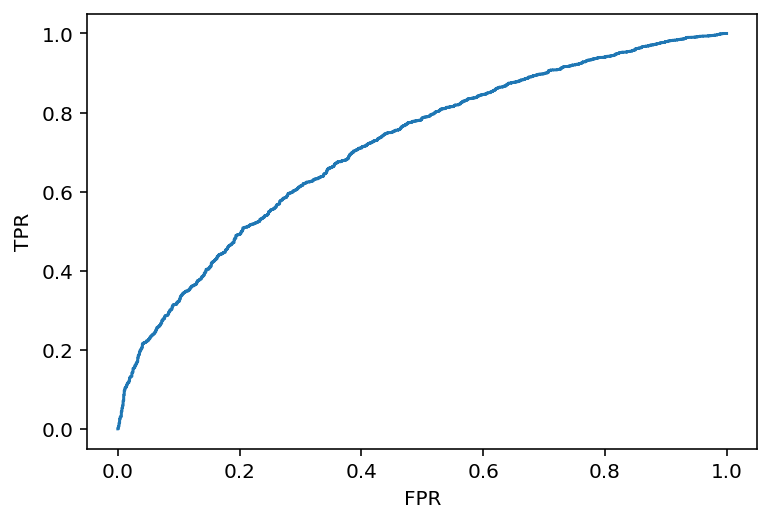

In [26]:
calc_auc(y_test, model.predict_proba(X_test)[:,1], plot_label='LR')

### Решающее дерево

1. Неустойчивы к входным данным
2. Склонны к переобучению
3. Быстро обучаются

=> хороший выбор для построения композиций


Обучаем решающее дерево

Ограничим глубину и минимальное кол-во объектов в листе для уменьшения переобучения

Предсказываем вероятность класса 1 и считаем ROC AUC

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(solver="liblinear", random_state=42)
dtr_clf = DecisionTreeClassifier( random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dtr', dtr_clf)],
    voting='hard')

In [28]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('dtr', DecisionTreeClassifier(random_state=42))])

In [29]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, dtr_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7773890225235075
DecisionTreeClassifier 0.6739558276842336
VotingClassifier 0.6735184780231795


### Классификатор с голосованием

In [30]:
from sklearn.ensemble import VotingClassifier

## Композиции моделей одного семейства

### Бэггинг

Самостоятельная реализация

##### На дереве

In [31]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.7780450470150886


In [33]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.6739558276842336


##### Логистический

# Часть 2. Случайный лес


**Важные гиперпараметры алгоритма**

a. Параметры деревьев
    1. criterion - критерий построения дерева
    2. max_depth - максимальная глубина дерева (больше глубина -> больше риск переобучения)
    3. min_samples_leaf - минимальное число объектов в листе (больше объектов -> меньше риск переобучения)

b. Параметры леса
    1. n_estimators - кол-во деревьев (чем больше тем лучше)
    2. max_features - число признаков случайного подпространства
    3. bootstrap - использовать ли бэггинг
    4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)

In [34]:
%%time
from sklearn.ensemble import RandomForestClassifier


Wall time: 0 ns


In [35]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, min_samples_split=14, max_depth=3, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.7721408265908594


In [36]:
X_test

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v112_N,v112_NULL,v112_O,v112_P,v112_Q,v112_R,v112_S,v112_T,v112_U,v112_V
35293,1.990219e+00,10.240067,5.991782,10.586369,1.955990,3.168705,0.581551,11.304348,6.542670,14.707965,...,0,0,0,0,0,0,0,0,0,0
17841,8.968135e-01,6.534818,2.504729,9.049150,1.911357,2.181441,0.912732,10.781249,1.291029,15.034169,...,0,0,0,0,0,0,0,0,0,0
104874,1.636883e+00,7.443242,4.139365,8.741405,2.434346,2.485115,1.519028,9.028518,1.312910,15.451105,...,1,0,0,0,0,0,0,0,0,0
73823,-3.032588e-07,4.992694,2.674514,8.874024,2.424242,1.247771,7.075681,10.572206,1.312911,14.173603,...,0,0,0,0,0,0,0,0,0,0
84834,1.636883e+00,7.443242,4.139365,8.741405,2.434346,2.485115,1.519028,9.028518,1.838074,15.451105,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55817,1.636883e+00,7.443242,4.139365,8.741405,2.434346,2.485115,1.519028,9.028518,1.575493,15.451105,...,1,0,0,0,0,0,0,0,0,0
20860,1.636883e+00,7.443242,4.139365,8.741405,2.434346,2.485115,1.519028,9.028518,1.553611,15.451105,...,0,0,0,0,0,0,0,0,0,1
105869,2.296353e+00,7.516619,3.862974,6.139878,2.141194,2.591156,0.050537,7.195122,6.542669,15.808170,...,0,0,0,0,0,0,0,0,0,0
26005,1.636883e+00,7.443242,4.139365,8.741405,2.434346,2.485115,1.519028,9.028518,0.503283,15.451105,...,0,0,0,0,0,0,0,0,0,0


In [37]:
rnd_clf.predict_proba(X_test)[:,0]

array([0.12223175, 0.26417704, 0.2535798 , ..., 0.1188527 , 0.2527065 ,
       0.28329313])

ROC AUC: 0.6853


0.6852999563504165

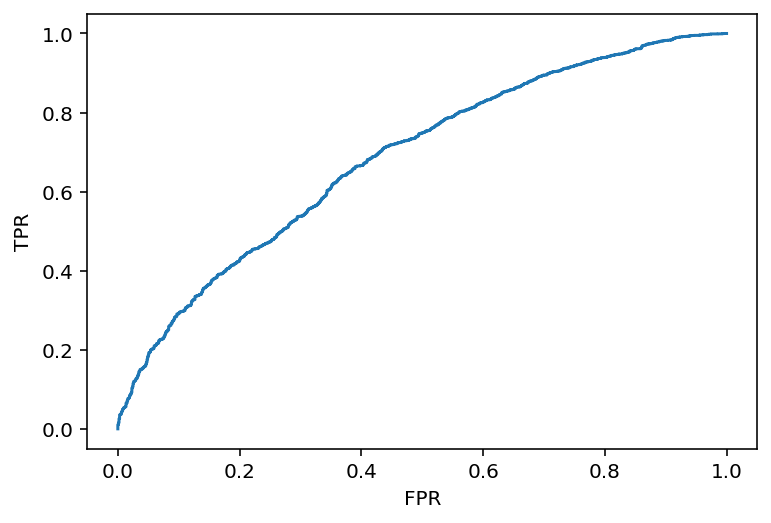

In [38]:
calc_auc(y_test, rnd_clf.predict_proba(X_test)[:,1], plot_label='T')

#### Важность признаков

В sklearn - усредненное по всем деревьям в ансамбле кол-во сплитов по признаку, взвешенное на прирост информации (Information gain) и долю объектов в вершине, в которой производится этот сплит

Это не единственный вариант, см здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важности признаков случайного леса лежат в артибуте **feature\_importances\_**

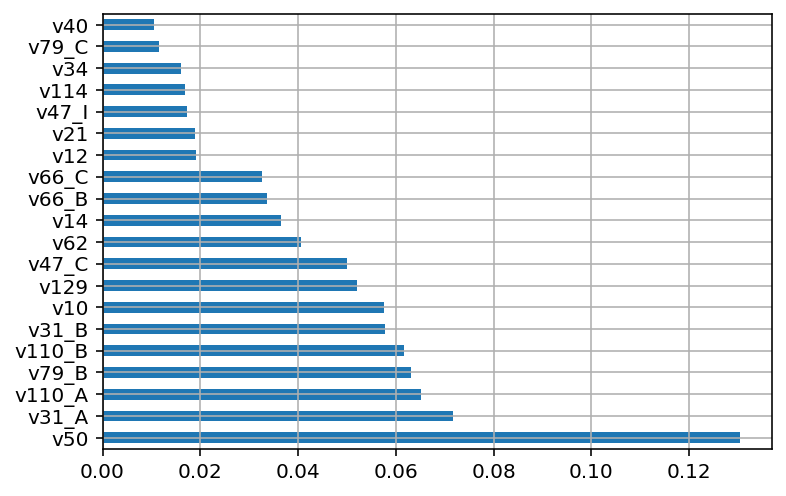

In [39]:
imp = pd.Series(rnd_clf.feature_importances_, index=X_test.columns).sort_values(ascending=False).iloc[:20].plot(kind='barh')
plt.grid();

In [40]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=500, min_samples_split=14, max_depth=7, max_features=0.8, max_leaf_nodes=16, min_samples_leaf=20, n_jobs=-1, random_state=42)
et.fit(X_train, y_train)

y_pred_et = et.predict(X_test)
print(accuracy_score(y_test, y_pred_et))

0.7819811939645747


ROC AUC: 0.7111


0.7111301273991643

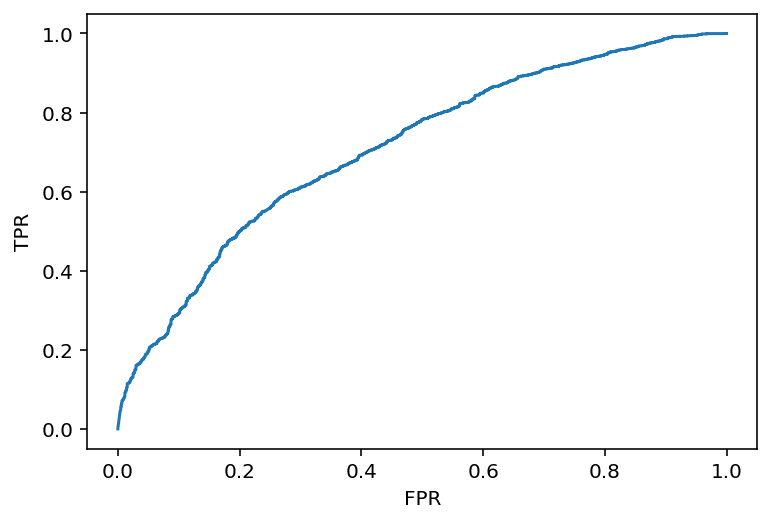

In [41]:
calc_auc(y_test, et.predict_proba(X_test)[:,1], plot_label='T')

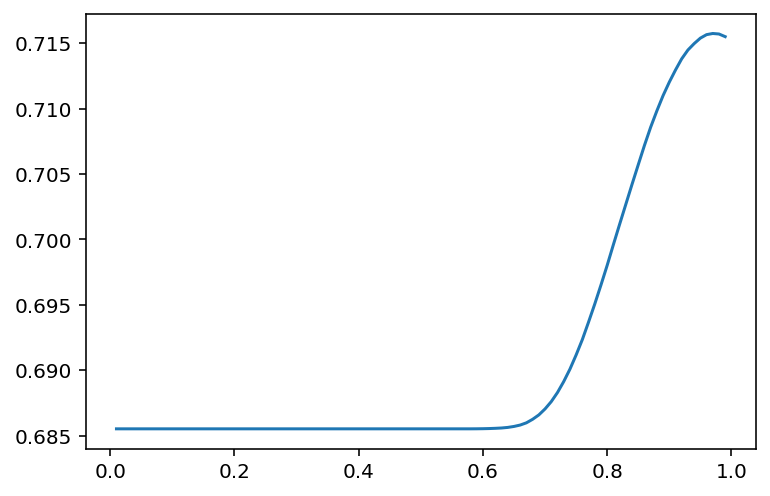

In [42]:
y = []
x = []

log_pred = log_clf.fit(X_train, y_train).predict_proba(X_test)
et_pred = dtr_clf.fit(X_train, y_train).predict_proba(X_test)

for i in range(1, 100):
    a = i * 0.01
    x.append(a)
    y.append(calc_auc(y_test, a * log_pred[:,1] + (1 - a) * et_pred[:, 1], prin=False))
    
plt.plot(x, y)

In [43]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

estimators = [
     ('rf', rnd_clf),
     ('svr', make_pipeline(StandardScaler(),
                           LinearSVC(random_state=42))),
     ('lr', log_clf)
]

clf = StackingClassifier(
     estimators=estimators, final_estimator=et
)

clf.fit(X_train, y_train).score(X_test, y_test)

0.7826372184561557

ROC AUC: 0.7159


0.7158697492078661

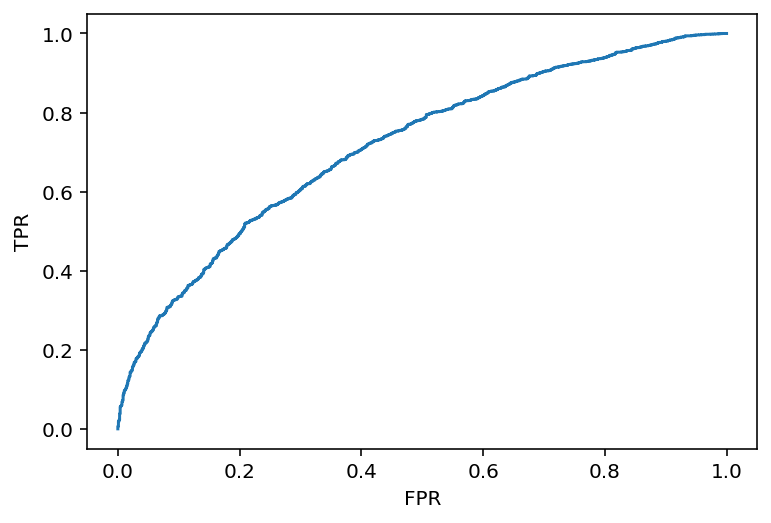

In [44]:
calc_auc(y_test, clf.predict_proba(X_test)[:,1], plot_label='T')

AdaBoosting

In [45]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

Train:
ROC AUC: 0.7545
Test:
ROC AUC: 0.7227


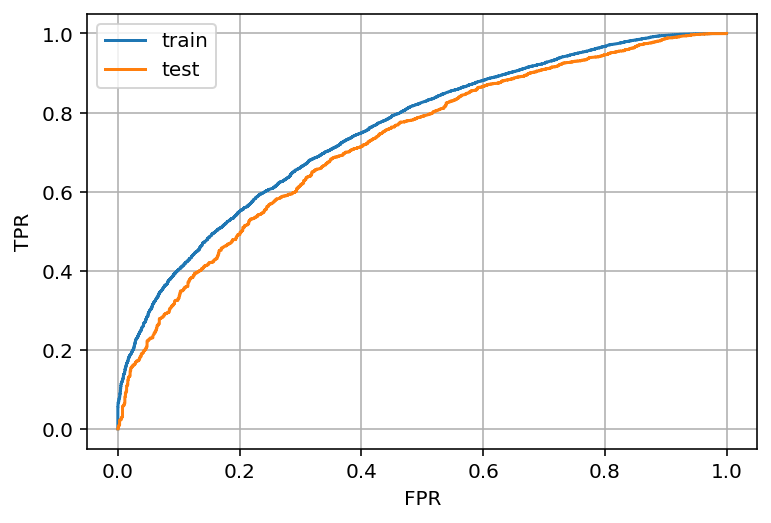

In [46]:
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_leaf=30, max_features=0.8, min_samples_split=30),
                             n_estimators=100, learning_rate=0.1, random_state=42)

clf_ada.fit(X_train, y_train)
y_pred_ada_test = clf_ada.predict_proba(X_test)[:, 1]
y_pred_ada_train = clf_ada.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_ada_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_ada_test, 'test')
plt.grid();
plt.legend();

Gradient Boosting

Train:
ROC AUC: 0.7496
Test:
ROC AUC: 0.7231
Wall time: 22.8 s


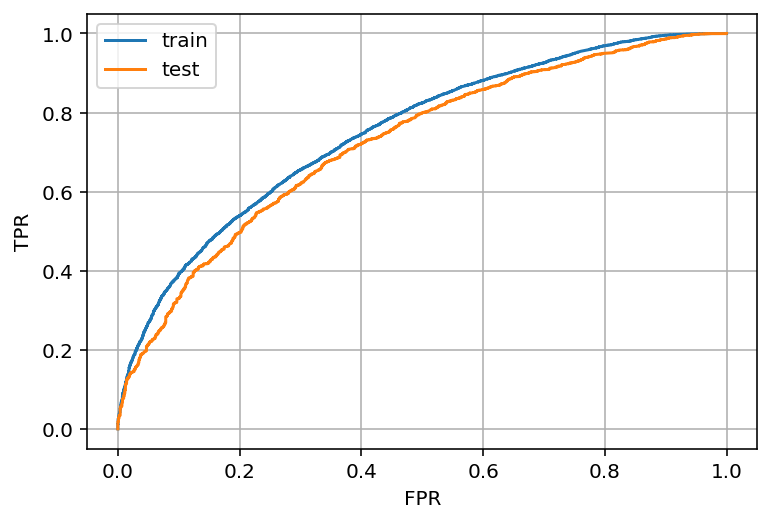

In [47]:
%%time
clf_gbm = GradientBoostingClassifier(max_depth=2, min_samples_leaf=30, n_estimators=100, learning_rate=0.1, 
                                     subsample=1.0, max_features=0.8, min_samples_split=30, random_state=42, 
                                     verbose=0)
# если subsample < 1.0 - получится стахастический градиентный спуск, алгоритм работать будет быстрее, 
# но точность может быть хуже

clf_gbm.fit(X_train, y_train)
y_pred_gbm_test = clf_gbm.predict_proba(X_test)[:, 1]
y_pred_gbm_train = clf_gbm.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_gbm_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_gbm_test, 'test')
plt.legend()
plt.grid();

In [48]:
import xgboost as xgb

In [49]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}

In [50]:
%%time
clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train)

[17:23:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8.47 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train:
ROC AUC: 0.7769
Test:
ROC AUC: 0.7288


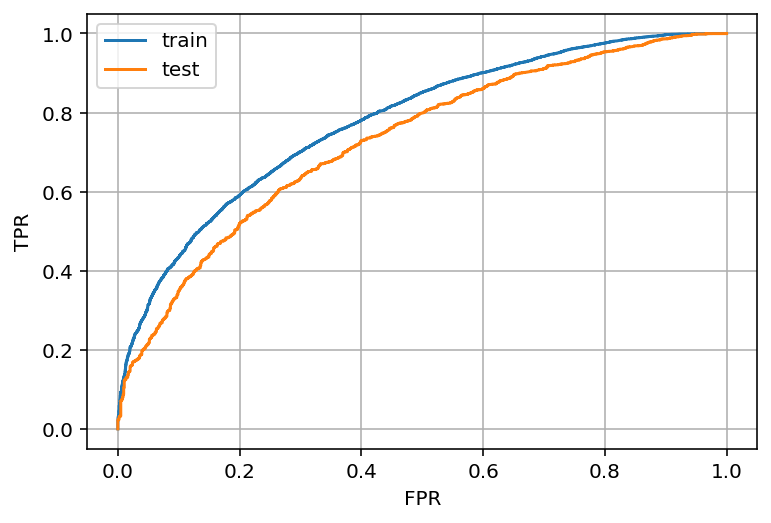

In [51]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.grid()
plt.legend();

In [52]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.69899	validation_1-auc:0.68220
[1]	validation_0-auc:0.70214	validation_1-auc:0.68661
[2]	validation_0-auc:0.71651	validation_1-auc:0.69848
[3]	validation_0-auc:0.71977	validation_1-auc:0.70079
[4]	validation_0-auc:0.72146	validation_1-auc:0.70319
[5]	validation_0-auc:0.72239	validation_1-auc:0.70508
[6]	validation_0-auc:0.72319	validation_1-auc:0.70615
[7]	validation_0-auc:0.72251	validation_1-auc:0.70663
[8]	validation_0-auc:0.72414	validation_1-auc:0.70771
[9]	validation_0-auc:0.72626	validation_1-auc:0.70975
[10]	validation_0-auc:0.72650	validation_1-auc:0.71028
[11]	validation_0-auc:0.72765	validation_1-auc:0.71128
[12]	validation_0-auc:0.72921	validation_1-auc:0.71196
[13]	validation_0-auc:0.72935	validation_1-auc:0.71191
[14]	validation_0-auc:0.73040	validation_1-auc:0.71300
[15]	validation_0-auc:0.73285	validation_1-auc:0.71456
[16]	validation_0-auc:0.73426	validation_1-auc:0.71494
[17]	validation_0-auc:0.73496	validation_1-auc:0.71468
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train:
ROC AUC: 0.7769
Test:
ROC AUC: 0.7288


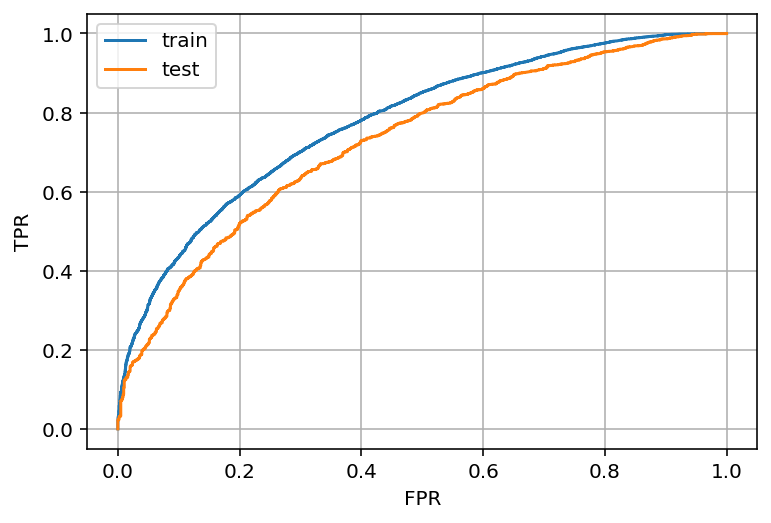

In [53]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.grid()
plt.legend();

In [54]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.69899	validation_1-auc:0.68220
[1]	validation_0-auc:0.70214	validation_1-auc:0.68661
[2]	validation_0-auc:0.71651	validation_1-auc:0.69848
[3]	validation_0-auc:0.71977	validation_1-auc:0.70079
[4]	validation_0-auc:0.72146	validation_1-auc:0.70319
[5]	validation_0-auc:0.72239	validation_1-auc:0.70508
[6]	validation_0-auc:0.72319	validation_1-auc:0.70615
[7]	validation_0-auc:0.72251	validation_1-auc:0.70663
[8]	validation_0-auc:0.72414	validation_1-auc:0.70771
[9]	validation_0-auc:0.72626	validation_1-auc:0.70975
[10]	validation_0-auc:0.72650	validation_1-auc:0.71028
[11]	validation_0-auc:0.72765	validation_1-auc:0.71128
[12]	validation_0-auc:0.72921	validation_1-auc:0.71196
[13]	validation_0-auc:0.72935	validation_1-auc:0.71191
[14]	validation_0-auc:0.73040	validation_1-auc:0.71300
[15]	validation_0-auc:0.73285	validation_1-auc:0.71456
[16]	validation_0-auc:0.73426	validation_1-auc:0.71494
[17]	validation_0-auc:0.73496	validation_1-auc:0.71468
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
%%time

params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.72892	validation_1-auc:0.69742
[1]	validation_0-auc:0.73976	validation_1-auc:0.70759
[2]	validation_0-auc:0.74278	validation_1-auc:0.70771
[3]	validation_0-auc:0.74526	validation_1-auc:0.70777
[4]	validation_0-auc:0.75155	validation_1-auc:0.71185
[5]	validation_0-auc:0.75396	validation_1-auc:0.71296
[6]	validation_0-auc:0.75614	validation_1-auc:0.71238
[7]	validation_0-auc:0.75740	validation_1-auc:0.71520
[8]	validation_0-auc:0.76087	validation_1-auc:0.71547
[9]	validation_0-auc:0.76211	validation_1-auc:0.71629
[10]	validation_0-auc:0.76348	validation_1-auc:0.71771
[11]	validation_0-auc:0.76457	validation_1-auc:0.71896
[12]	validation_0-auc:0.76563	validation_1-auc:0.71958
[13]	validation_0-auc:0.76644	validation_1-auc:0.72065
[14]	validation_0-auc:0.76808	validation_1-auc:0.72033
[15]	validation_0-auc:0.76978	validation_1-auc:0.72047
[16]	validation_0-auc:0.77051	validation_1-auc:0.72013
[17]	validation_0-auc:0.77131	validation_1-auc:0.72064
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

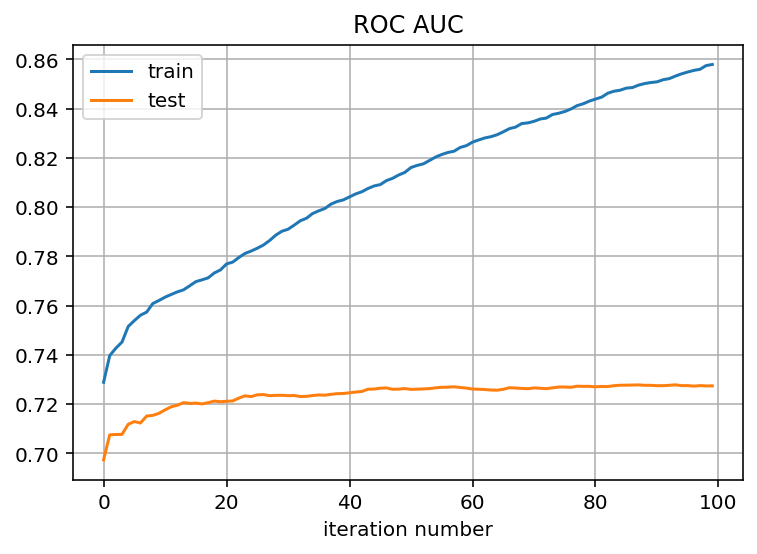

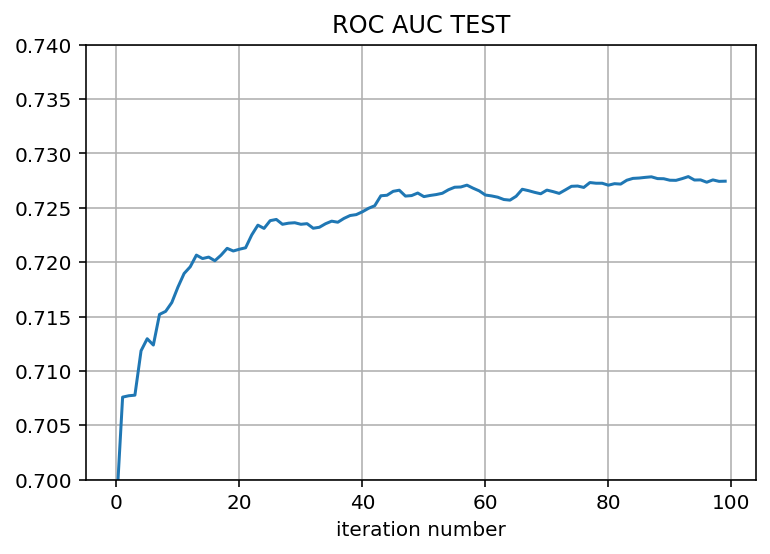

In [56]:
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['auc'],
                         'test': clf.evals_result()['validation_1']['auc']})
res = save_online_metric(clf_xgb)
res.plot(title='ROC AUC')
plt.xlabel('iteration number')
plt.grid();
plt.figure()
res.test.plot(ylim=(0.7, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')
plt.grid();

In [57]:
%%time
params = {'n_estimators': 50,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

best_params = params

[0]	validation_0-auc:0.72892	validation_1-auc:0.69742
[1]	validation_0-auc:0.73653	validation_1-auc:0.70623
[2]	validation_0-auc:0.74068	validation_1-auc:0.70614
[3]	validation_0-auc:0.74188	validation_1-auc:0.70625
[4]	validation_0-auc:0.74668	validation_1-auc:0.71244
[5]	validation_0-auc:0.74835	validation_1-auc:0.71381
[6]	validation_0-auc:0.75073	validation_1-auc:0.71515
[7]	validation_0-auc:0.75195	validation_1-auc:0.71636
[8]	validation_0-auc:0.75334	validation_1-auc:0.71746
[9]	validation_0-auc:0.75412	validation_1-auc:0.71786
[10]	validation_0-auc:0.75438	validation_1-auc:0.71808
[11]	validation_0-auc:0.75488	validation_1-auc:0.71795
[12]	validation_0-auc:0.75513	validation_1-auc:0.71804
[13]	validation_0-auc:0.75561	validation_1-auc:0.71774
[14]	validation_0-auc:0.75640	validation_1-auc:0.71826
[15]	validation_0-auc:0.75733	validation_1-auc:0.71922
[16]	validation_0-auc:0.75797	validation_1-auc:0.71927
[17]	validation_0-auc:0.75798	validation_1-auc:0.71972
[18]	validation_0-au

In [58]:
def find_params(clf, param_grid):
    clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=[(np.arange(len(X_train)),
                                                               np.arange(len(X_test)) + len(X_train))],
                  verbose=3)

    clf.fit(pd.concat([X_train, X_test]).values, pd.concat([y_train, y_test]).values)
    best_params = clf.best_estimator_.get_params()
    print('Best test ROC AUC: ', clf.best_score_)
    print('Best params: ', best_params)
    return best_params

In [59]:
%%time

from sklearn.model_selection import GridSearchCV

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_child_weight': [10, 20, 100]#[1, 5, 10]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] max_depth=3, min_child_weight=10 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[17:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .... max_depth=3, min_child_weight=10, score=0.715, total=   4.2s
[CV] max_depth=3, min_child_weight=20 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[17:24:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .... max_depth=3, min_child_weight=20, score=0.715, total=   4.6s
[CV] max_depth=3, min_child_weight=100 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s


[17:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ... max_depth=3, min_child_weight=100, score=0.714, total=   3.8s
[CV] max_depth=5, min_child_weight=10 ................................
[17:24:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .... max_depth=5, min_child_weight=10, score=0.722, total=   6.4s
[CV] max_depth=5, min_child_weight=20 ................................
[17:24:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.0min finished


[17:25:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best test ROC AUC:  0.7260189568564908
Best params:  {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 20, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 50, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Wall time: 1min 14s


In [60]:
%%time

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'gamma': np.linspace(0, 0.5, 5)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[17:25:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ........................... gamma=0.0, score=0.726, total=  11.4s
[CV] gamma=0.125 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s


[17:25:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ......................... gamma=0.125, score=0.726, total=  11.8s
[CV] gamma=0.25 ......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.1s remaining:    0.0s


[17:26:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .......................... gamma=0.25, score=0.726, total=  10.4s
[CV] gamma=0.375 .....................................................
[17:26:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ......................... gamma=0.375, score=0.726, total=  10.4s
[CV] gamma=0.5 .......................................................
[17:26:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   53.8s finished


[17:26:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best test ROC AUC:  0.7263089575142242
Best params:  {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.125, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 20, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 50, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Wall time: 1min 6s


In [61]:
%%time
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] colsample_bytree=0.5, subsample=0.5 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[17:26:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] . colsample_bytree=0.5, subsample=0.5, score=0.723, total=   5.7s
[CV] colsample_bytree=0.5, subsample=0.6 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[17:26:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] . colsample_bytree=0.5, subsample=0.6, score=0.725, total=   6.3s
[CV] colsample_bytree=0.5, subsample=0.7 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s


[17:26:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] . colsample_bytree=0.5, subsample=0.7, score=0.719, total=   6.8s
[CV] colsample_bytree=0.5, subsample=0.8 .............................
[17:27:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] . colsample_bytree=0.5, subsample=0.8, score=0.723, total=   7.0s
[CV] colsample_bytree=0.5, subsample=0.9 .............................
[17:27:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:

[CV] . colsample_bytree=0.8, subsample=0.7, score=0.725, total=   9.7s
[CV] colsample_bytree=0.8, subsample=0.8 .............................
[17:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] . colsample_bytree=0.8, subsample=0.8, score=0.726, total=  10.2s
[CV] colsample_bytree=0.8, subsample=0.9 .............................
[17:29:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] . colsample_bytree=0.8, subsample=0.9, score=0.725, total=  10.6s
[CV] colsample_bytree=0.8

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  5.6min finished


[17:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best test ROC AUC:  0.7270634484475588
Best params:  {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0.125, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 20, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 50, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Wall time: 5min 46s


In [62]:
%%time

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'reg_alpha': [0, 0.0001, 0.001, 0.1, 1],
    'reg_lambda': [0, 0.0001, 0.001, 0.1, 1]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV] reg_alpha=0, reg_lambda=0 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[17:32:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ........... reg_alpha=0, reg_lambda=0, score=0.728, total=   6.7s
[CV] reg_alpha=0, reg_lambda=0.0001 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[17:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ...... reg_alpha=0, reg_lambda=0.0001, score=0.728, total=   6.7s
[CV] reg_alpha=0, reg_lambda=0.001 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s


[17:32:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ....... reg_alpha=0, reg_lambda=0.001, score=0.728, total=   6.9s
[CV] reg_alpha=0, reg_lambda=0.1 .....................................
[17:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ......... reg_alpha=0, reg_lambda=0.1, score=0.729, total=   6.7s
[CV] reg_alpha=0, reg_lambda=1 .......................................
[17:33:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:

[CV] ........... reg_alpha=1, reg_lambda=0, score=0.726, total=   6.4s
[CV] reg_alpha=1, reg_lambda=0.0001 ..................................
[17:34:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ...... reg_alpha=1, reg_lambda=0.0001, score=0.726, total=   6.4s
[CV] reg_alpha=1, reg_lambda=0.001 ...................................
[17:35:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ....... reg_alpha=1, reg_lambda=0.001, score=0.726, total=   6.5s
[CV] reg_alpha=1, reg_lam

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.8min finished


[17:35:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best test ROC AUC:  0.7285746046396844
Best params:  {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0.125, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 20, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 50, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Wall time: 2min 54s


In [63]:
%%time

best_params['learning_rate'] = 0.01
best_params['n_estimators'] = 500

clf_xgb = xgb.XGBClassifier(**best_params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.73278	validation_1-auc:0.67824
[1]	validation_0-auc:0.75258	validation_1-auc:0.69615
[2]	validation_0-auc:0.76130	validation_1-auc:0.69941
[3]	validation_0-auc:0.76445	validation_1-auc:0.70146
[4]	validation_0-auc:0.76962	validation_1-auc:0.70717
[5]	validation_0-auc:0.77114	validation_1-auc:0.71046
[6]	validation_0-auc:0.77211	validation_1-auc:0.71228
[7]	validation_0-auc:0.77333	validation_1-auc:0.71246
[8]	validation_0-auc:0.77353	validation_1-auc:0.71376
[9]	validation_0-auc:0.77455	validation_1-auc:0.71325
[10]	validation_0-auc:0.77532	validation_1-auc:0.71295
[11]	validation_0-auc:0.77627	validation_1-auc:0.71369
[12]	validation_0-auc:0.77757	validation_1-auc:0.71502
[13]	validation_0-auc:0.77885	validation_1-auc:0.71567
[14]	validation_0-auc:0.77946	validation_1-auc:0.71687
[15]	validation_0-auc:0.77951	validation_1-auc:0.71795
[16]	validation_0-auc:0.77989	validation_1-auc:0.71829
[17]	validation_0-auc:0.78015	validation_1-auc:0.71860
[18]	validation_0-au

[149]	validation_0-auc:0.80213	validation_1-auc:0.72751
[150]	validation_0-auc:0.80235	validation_1-auc:0.72756
[151]	validation_0-auc:0.80244	validation_1-auc:0.72759
[152]	validation_0-auc:0.80265	validation_1-auc:0.72762
[153]	validation_0-auc:0.80287	validation_1-auc:0.72744
[154]	validation_0-auc:0.80292	validation_1-auc:0.72736
[155]	validation_0-auc:0.80302	validation_1-auc:0.72730
[156]	validation_0-auc:0.80313	validation_1-auc:0.72722
[157]	validation_0-auc:0.80324	validation_1-auc:0.72730
[158]	validation_0-auc:0.80330	validation_1-auc:0.72732
[159]	validation_0-auc:0.80336	validation_1-auc:0.72732
[160]	validation_0-auc:0.80351	validation_1-auc:0.72738
[161]	validation_0-auc:0.80367	validation_1-auc:0.72753
[162]	validation_0-auc:0.80385	validation_1-auc:0.72749
[163]	validation_0-auc:0.80396	validation_1-auc:0.72740
[164]	validation_0-auc:0.80406	validation_1-auc:0.72727
[165]	validation_0-auc:0.80428	validation_1-auc:0.72738
[166]	validation_0-auc:0.80445	validation_1-auc:

[296]	validation_0-auc:0.82078	validation_1-auc:0.72967
[297]	validation_0-auc:0.82088	validation_1-auc:0.72976
[298]	validation_0-auc:0.82094	validation_1-auc:0.72977
[299]	validation_0-auc:0.82112	validation_1-auc:0.72976
[300]	validation_0-auc:0.82127	validation_1-auc:0.72973
[301]	validation_0-auc:0.82138	validation_1-auc:0.72972
[302]	validation_0-auc:0.82149	validation_1-auc:0.72976
[303]	validation_0-auc:0.82156	validation_1-auc:0.72977
[304]	validation_0-auc:0.82169	validation_1-auc:0.72976
[305]	validation_0-auc:0.82181	validation_1-auc:0.72976
[306]	validation_0-auc:0.82191	validation_1-auc:0.72980
[307]	validation_0-auc:0.82207	validation_1-auc:0.72979
[308]	validation_0-auc:0.82216	validation_1-auc:0.72987
[309]	validation_0-auc:0.82227	validation_1-auc:0.72985
[310]	validation_0-auc:0.82238	validation_1-auc:0.72983
[311]	validation_0-auc:0.82248	validation_1-auc:0.72982
[312]	validation_0-auc:0.82267	validation_1-auc:0.72982
[313]	validation_0-auc:0.82285	validation_1-auc:

[443]	validation_0-auc:0.83829	validation_1-auc:0.73126
[444]	validation_0-auc:0.83838	validation_1-auc:0.73132
[445]	validation_0-auc:0.83853	validation_1-auc:0.73135
[446]	validation_0-auc:0.83860	validation_1-auc:0.73133
[447]	validation_0-auc:0.83870	validation_1-auc:0.73132
[448]	validation_0-auc:0.83884	validation_1-auc:0.73128
[449]	validation_0-auc:0.83899	validation_1-auc:0.73130
[450]	validation_0-auc:0.83908	validation_1-auc:0.73125
[451]	validation_0-auc:0.83917	validation_1-auc:0.73128
[452]	validation_0-auc:0.83934	validation_1-auc:0.73131
[453]	validation_0-auc:0.83950	validation_1-auc:0.73130
[454]	validation_0-auc:0.83954	validation_1-auc:0.73127
[455]	validation_0-auc:0.83964	validation_1-auc:0.73125
[456]	validation_0-auc:0.83969	validation_1-auc:0.73126
[457]	validation_0-auc:0.83979	validation_1-auc:0.73130
[458]	validation_0-auc:0.83997	validation_1-auc:0.73134
[459]	validation_0-auc:0.84008	validation_1-auc:0.73135
[460]	validation_0-auc:0.84025	validation_1-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.125, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=20, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

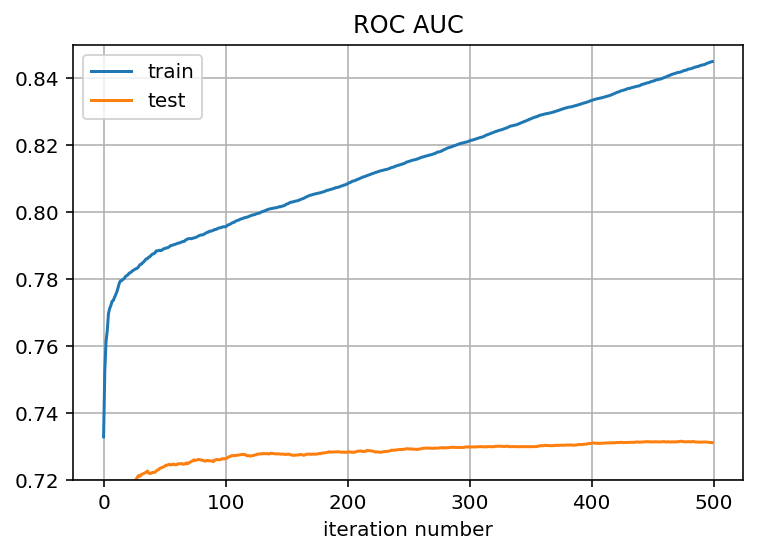

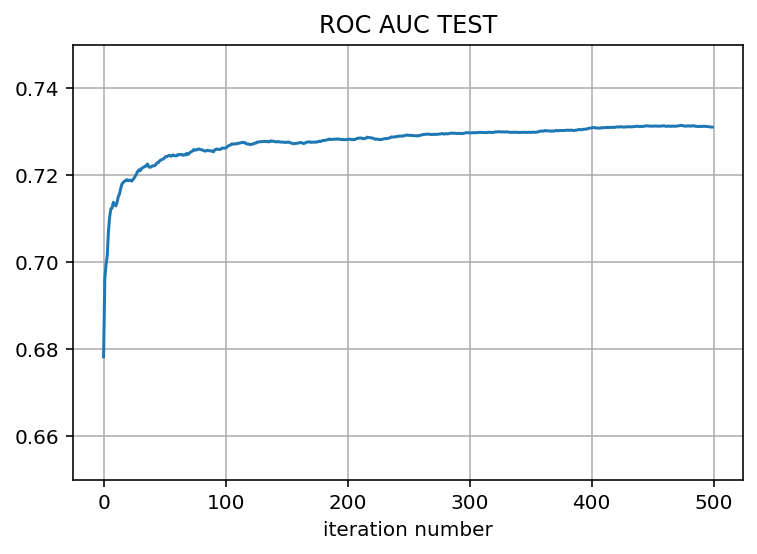

In [64]:
res = save_online_metric(clf_xgb)
res.plot(ylim=(0.72, 0.85), title='ROC AUC')
plt.xlabel('iteration number')
plt.grid();
plt.figure()
res.test.plot(ylim=(0.65, 0.75), title='ROC AUC TEST')
plt.xlabel('iteration number')
plt.grid();

In [65]:
%%time

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#функция, которую будем МИНИМИЗИРОВАТЬ
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print("Training with params : ", params)
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred_xgb_test = clf.predict_proba(X_test)[:, 1]
    auc = calc_auc(y_test, y_pred_xgb_test, prin=False)
    result = {'loss': 1-auc, 'status': STATUS_OK}
    print('TEST ROC AUC: {0:.4f}'.format(auc))
    return result



space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'silent' : 1,
         'n_estimators': 100,
         'learning_rate': 0.1
         }
trials = Trials()

best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)

Training with params :                                                                                                                     
{'colsample_bytree': 0.8, 'gamma': 0.75, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 7.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.5, 'n_jobs': -1}
[17:37:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541:                                       
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:37:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric i

TEST ROC AUC: 0.7150                                                                                                                       
Training with params :                                                                                                                     
{'colsample_bytree': 0.8500000000000001, 'gamma': 0.9, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 10.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.55, 'n_jobs': -1}
[17:38:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541:                                       
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:38:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting i

[17:40:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TEST ROC AUC: 0.7224                                                                                                                       
Training with params :                                                                                                                     
{'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.6000000000000001, 'n_jobs': -1}
[17:40:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541:                                       
Parameters: { silent } might not be used.

  This may not be accurate due to some para

In [66]:
best

{'colsample_bytree': 0.6000000000000001,
 'gamma': 0.9500000000000001,
 'max_depth': 6.0,
 'min_child_weight': 3.0,
 'subsample': 0.9}

In [67]:
trials.best_trial

{'state': 2,
 'tid': 8,
 'spec': None,
 'result': {'loss': 0.2670149120675607, 'status': 'ok'},
 'misc': {'tid': 8,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [8],
   'gamma': [8],
   'max_depth': [8],
   'min_child_weight': [8],
   'subsample': [8]},
  'vals': {'colsample_bytree': [0.6000000000000001],
   'gamma': [0.9500000000000001],
   'max_depth': [6.0],
   'min_child_weight': [3.0],
   'subsample': [0.9]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 12, 24, 14, 38, 57, 745000),
 'refresh_time': datetime.datetime(2020, 12, 24, 14, 39, 9, 817000)}

In [68]:
best_new = {'colsample_bytree': 0.75,
 'gamma': 0.75,
 'max_depth': 3,
 'min_child_weight': 3.0,
 'subsample': 0.6000000000000001,
 'n_estimators': 100,
 'learning_rate': 0.1         
}

In [69]:
%%time
clf_xgb = xgb.XGBClassifier(**best_new)
clf_xgb.fit(X_train, y_train)

[17:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7.28 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0.75, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6000000000000001, tree_method='exact',
              validate_parameters=1, verbosity=None)

Train:
ROC AUC: 0.7774
Test:
ROC AUC: 0.7284


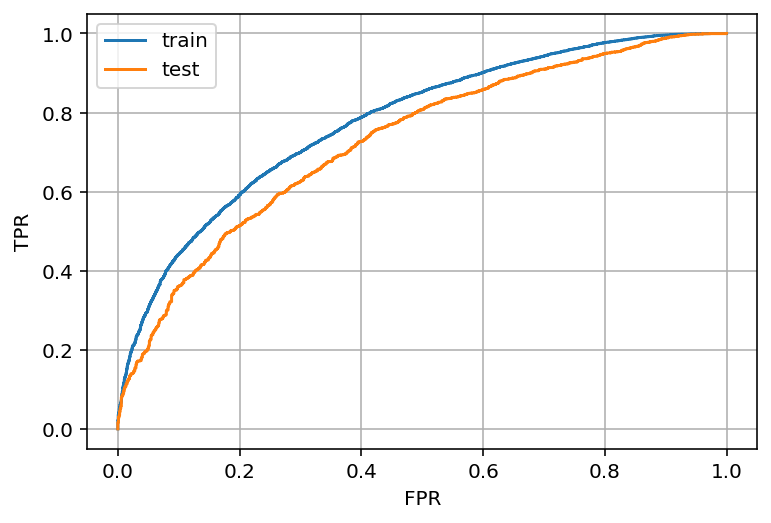

In [70]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.grid()
plt.legend();

Wall time: 148 ms


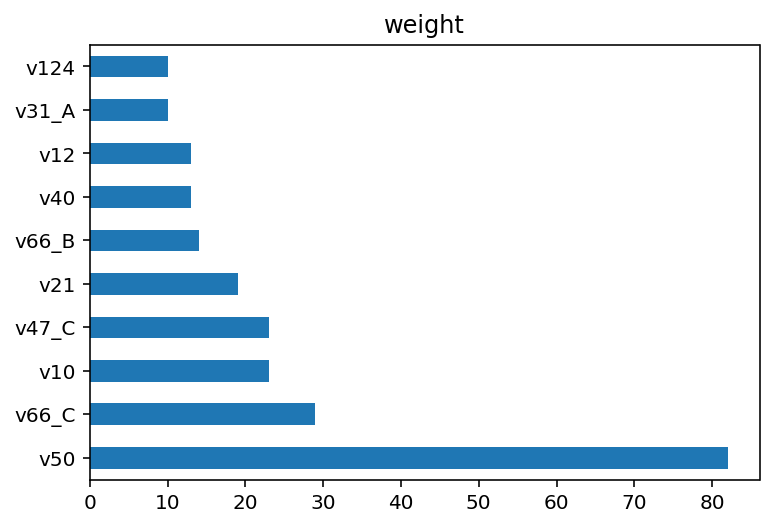

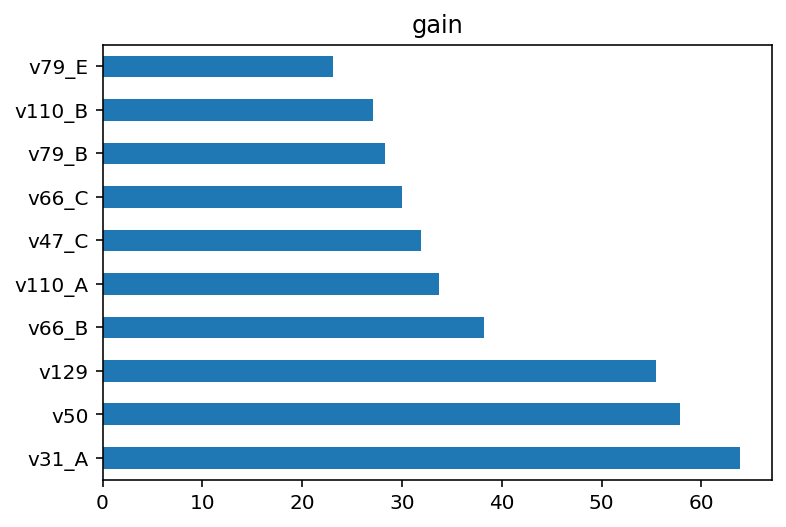

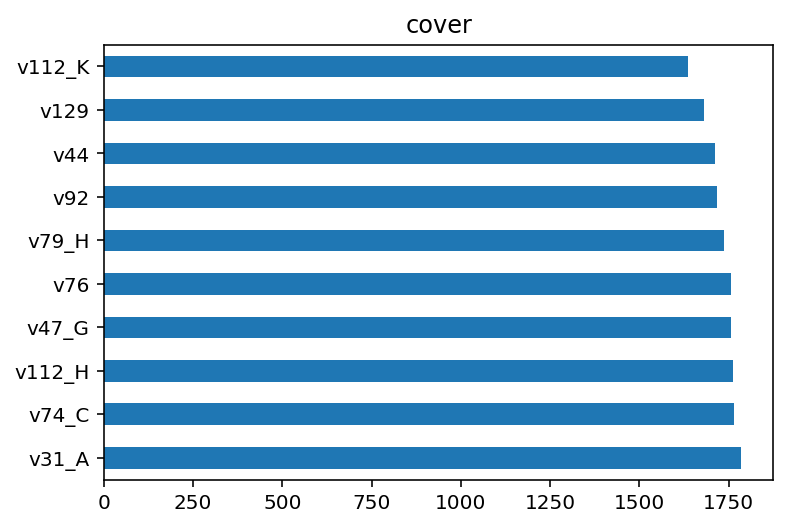

In [71]:
%%time

bst = clf_xgb.get_booster()

for kind in ['weight', 'gain', 'cover']:
    imp = pd.Series(bst.get_score(importance_type=kind))
    plt.figure()
    imp.sort_values(ascending=False).iloc[:10].plot(kind='barh', title=kind)

In [72]:
import xgbfir
xgbfir.saveXgbFI(clf_xgb, OutputXlsxFile='xgbfi_report.xlsx')

In [73]:
pd.read_excel('xgbfi_report.xlsx', engine='openpyxl', sheet_name=0)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,v50,4742.588843,82,57.067903,0.695950,57.836449,3986.021180,1,1,1,11,2,1,2.833333,27.890244,0.926829
1,v66_C,869.152006,29,14.848628,0.512022,29.970759,445.568196,2,2,2,31,7,3,7.833333,21.551724,1.344828
2,v47_C,734.013384,23,12.077533,0.525110,31.913625,374.837858,3,3,3,28,6,4,7.833333,17.434783,1.695652
3,v31_A,638.934319,10,8.196577,0.819658,63.893432,610.997151,4,9,6,6,1,2,4.666667,15.800000,0.600000
4,v66_B,535.621330,14,6.261034,0.447217,38.258666,202.937504,5,6,9,45,4,5,12.333333,20.571429,1.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,v112_K,19.096370,2,1.828590,0.914295,9.548185,17.243623,96,95,41,1,69,47,58.166667,67.500000,1.000000
96,v52_F,18.942901,2,0.081231,0.040615,9.471450,0.765918,97,96,98,97,72,98,93.000000,77.000000,2.000000
97,v70,18.418818,2,0.977294,0.488647,9.209409,11.630971,98,97,69,35,76,64,73.166667,61.500000,2.000000
98,v93,18.374420,2,1.176772,0.588386,9.187210,10.367085,99,98,60,18,77,70,70.333333,71.500000,1.000000


In [74]:
from catboost import CatBoostClassifier, Pool

In [75]:
train_data = X_train
train_labels = y_train
eval_data = X_test
eval_labels = y_test
eval_dataset = Pool(eval_data,
                    eval_labels)





clf_catb = CatBoostClassifier(
                           l2_leaf_reg=4000,
                           iterations=1000,
                           learning_rate=0.3,
                           eval_metric='AUC',
                            max_depth=7,
                           loss_function='CrossEntropy',
                           use_best_model=True,
                           custom_metric=['Accuracy',
                                          'AUC:hints=skip_train~false'],
                                                     )

In [76]:
clf_catb.fit(train_data,
          train_labels,
          eval_set=eval_dataset,
          verbose=False,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train:
ROC AUC: 0.8213
Test:
ROC AUC: 0.7309


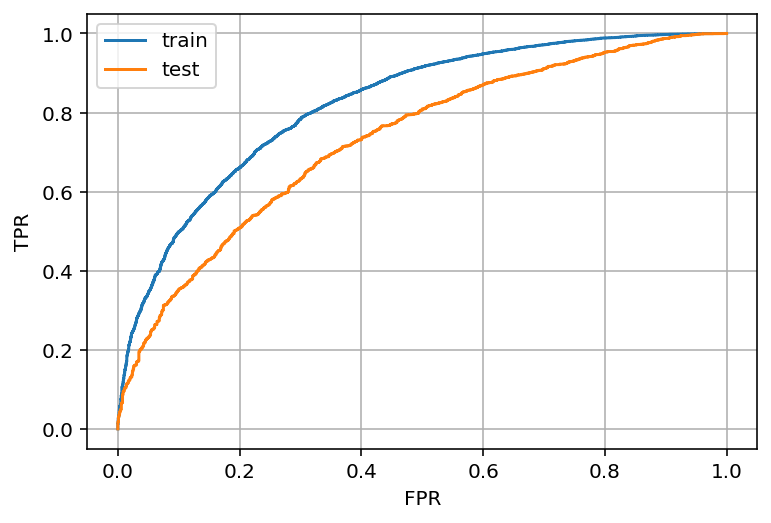

In [77]:
y_pred_catb_test = clf_catb.predict_proba(X_test)[:, 1]
y_pred_catb_train = clf_catb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_catb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_catb_test, 'test')
plt.grid()
plt.legend();